# Finanças Quantitativas Lista 3

**Aluno: Mário Augusto Filho**

Link da lista -> https://virtual.ufmg.br/20201/pluginfile.php/684522/mod_resource/content/0/2020_lista3.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

# Questão 2

## Dados

In [2]:
df_prices = pd.read_csv('../data/IBOV.csv', parse_dates=['Date'], index_col='Date')
ibov = df_prices['IBOV'].dropna().pct_change()

df_prices.drop('IBOV', axis=1, inplace=True)
df_returns = df_prices.pct_change().dropna()

in_sample = df_returns.loc['2019-01-02':'2020-01-02']
print(f'in-sample shape: {in_sample.shape}')
out_of_sample = df_returns.loc['2020-01-03':]
print(f'out-of-sample shape: {out_of_sample.shape}')

in-sample shape: (249, 71)
out-of-sample shape: (149, 71)


## Definindo modelos de otimização

### Modelo que minimiza CVaR

In [3]:
from docplex.mp.model import Model
def min_cvar(N, T, R, u, u_hat, alpha, w_ub, w_lb):
    
    # instancia novo modelo
    model = Model(name='Minimize CVaR')
    
    # variáveis de decisão:
    w = model.continuous_var_list(keys=R.columns, name='w', ub=w_ub, lb=w_lb)
    d = model.binary_var_list(keys=R.index, name='z')
    theta = model.continuous_var(name='theta') 
    
    # Restrições:
    # Restrição 3
    rp = [model.sum([R.values[t][i] * w[i] for i in range(N)]) for t in range(T)] 
    # Restrição 1
    model.add_constraints([d[t] >= (-theta - rp[t]) for t in range(T)])
    # Restrição 2
    model.add_constraints([d[t] >= 0 for t in range(T)])
    # Restrição 4 (retorno esperado)
    model.add_constraint(model.sum([w[i] * u[i] for i in range(N)]) >= u_hat)
    # Restrição 5 (somátorio dos pesos)
    model.add_constraint(model.sum(w) == 1)
    
    # Função objetivo
    model.minimize(theta + ((1/(T*alpha)) * model.sum(d)))

    # Resolvendo modelo
    model.solve()
    print(model.get_solve_details())
    
    # DataFrame
    weights = pd.DataFrame()
    weights['ativo'] = R.columns
    weights['peso'] = [w[i].solution_value for i in range(N)]
    return weights

### Modelo de Markowitz (minimizando variância)

In [4]:
def markowitz(covariance_matrix, w_ub, w_lb, returns=None, min_return=None):

    model = Model(name='markowitz')
    model.float_precision = 4 # setando modelo para precisão de 4 casa decimais
    N = len(covariance_matrix.columns) # constante (número de ativos)

    # variáveis de decisão 
    w = model.continuous_var_list(covariance_matrix.columns, name='w', ub=w_ub, lb=w_lb)

    # restrições
    model.add_constraint(model.sum(w) == 1) # pesos
    if returns is not None: # retorno esperado
        model.add_constraint(model.sum([w[i] * returns.values[i] for i in range(N)]) >= min_return)

    # função objetivo
    corr_exp = model.sum([1/2 * w[i] * w[j] * covariance_matrix.values[i][j] for i in range(N) for j in range(N)])
    model.minimize(corr_exp)

    # resolve modelo
    model.solve()
    print(model.get_solve_details())

    # DataFrame
    weights = pd.DataFrame()
    weights['ativo'] = R.columns
    weights['peso'] = [w[i].solution_value for i in range(N)]
    return weights

## Resolvendo os modelos

### Definindo constantes

In [5]:
# Definindo constantes
N = in_sample.shape[1] # Quantidade de ativos
T = in_sample.shape[0] # Quantidade de cenários
R = in_sample # A opção de R ser um DataFrame e não uma matriz é para preservar o nome das colunas
p = [1/T for i in range(T)] # Cenários equiprovávies
u = [sum(p * R[ativo]) for ativo in R.columns] # Retornos esperados dado probabilidades dos cenários
u_hat = 0.0001 # Retorno mínimo diário
alpha = 0.05 # alpha do CVaR
w_ub = 0.15 # peso máximo que um ativo pode receber
w_lb = -1 # peso mínimo que um ativo pode receber

### Resolvendo modelo de Markowitz (minimizando variância)

status  = optimal
time    = 0.00540304 s.
problem = QP



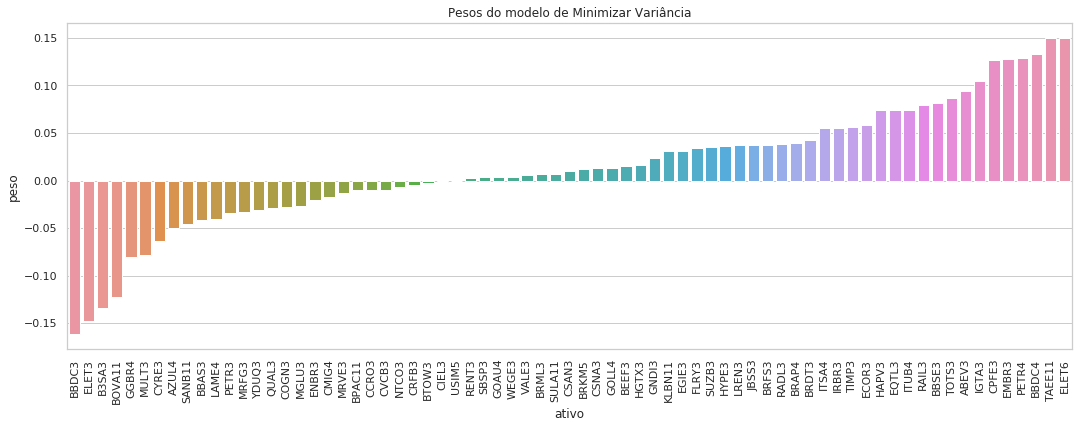

In [6]:
# Resolver modelo
mkw_weights = markowitz(covariance_matrix=R.cov(), w_ub=w_ub, w_lb=w_lb, returns=R.mean(), min_return=u_hat)
mkw_weights.sort_values('peso', inplace=True)
# Plota pesos
plt.figure(figsize=(18, 6))
plt.title('Pesos do modelo de Minimizar Variância')
sns.barplot(mkw_weights['ativo'], mkw_weights['peso'])
plt.xticks(rotation=90)
plt.show()

### Resolvendo modelo de minimizar CVaR

status  = integer optimal solution
time    = 0.0558031 s.
problem = MILP
gap     = 0%



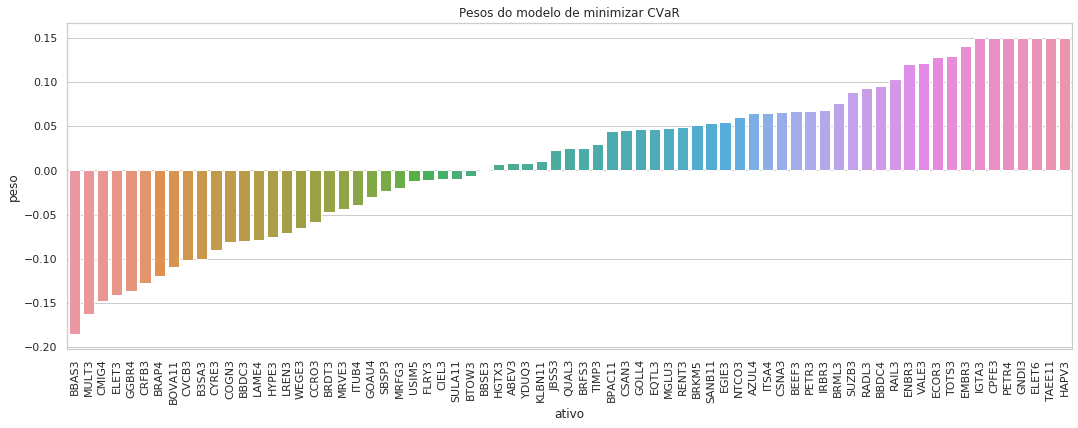

In [7]:
# Resolver modelo
cvar_weights = min_cvar(N, T, R, u, u_hat, alpha, w_ub, w_lb)
cvar_weights.sort_values('peso', inplace=True)
# Plota pesos
plt.figure(figsize=(18, 6))
plt.title('Pesos do modelo de minimizar CVaR')
sns.barplot(cvar_weights['ativo'], cvar_weights['peso'])
plt.xticks(rotation=90)
plt.show()

## Retorno dos portfólios

In [8]:
cvar_weights.set_index('ativo', inplace=True)
cvar_model_returns = out_of_sample.apply(lambda row: row[cvar_weights.index] * cvar_weights['peso'], axis=1).sum(axis=1)

mkw_weights.set_index('ativo', inplace=True)
mkw_model_returns = out_of_sample.apply(lambda row: row[mkw_weights.index] * mkw_weights['peso'], axis=1).sum(axis=1)

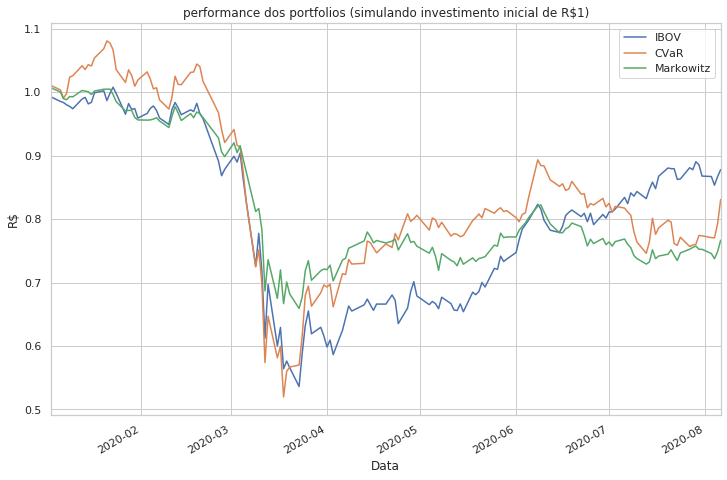

In [14]:
plt.figure(figsize=(12, 8))
ibov.loc[out_of_sample.index].add(1).cumprod().plot(
    label='IBOV', title='performance dos portfolios (simulando investimento inicial de R$1)')
cvar_model_returns.add(1).cumprod().plot(label='CVaR')
mkw_model_returns.add(1).cumprod().plot(label='Markowitz')
plt.xlabel('Data')
plt.ylabel('R$')
plt.legend()
plt.show()

## Métricas dos portfólios

In [20]:
def sharpe_ratio(returns, risk_free_rate=0.0):
    return (np.nanmean(returns) - risk_free_rate) / np.nanstd(returns)

def cvar(returns, alpha=0.05):
    sorted_returns = sorted(returns)
    n_returns_at_risk = int(len(sorted_returns) * alpha)
    return np.nanmean(sorted_returns[: n_returns_at_risk])

def drawdown(returns):
    cumsum = np.cumsum(returns)
    cum_roll_max = pd.Series(cumsum).cummax()
    drawdown = cumsum - cum_roll_max

    return drawdown


def get_metrics(returns, risk_free_rate=0.0):
    series_metrics = pd.Series()
    series_metrics["Retorno esperado"] = returns.mean()
    series_metrics["Desvio padrão"] = np.nanstd(returns)
    series_metrics["CVaR 5%"] = cvar(returns, alpha=0.05)
    series_metrics["Sharpe ratio"] = sharpe_ratio(returns, risk_free_rate)
    series_metrics["STARR ratio 5%"] = series_metrics["Retorno esperado"]/series_metrics["CVaR 5%"]
    series_metrics["Drawdown máximo"] = np.nanmin(drawdown(returns))

    return series_metrics

In [23]:
df_pr = pd.concat([ibov.loc[out_of_sample.index], cvar_model_returns, mkw_model_returns], axis=1)
df_pr.columns = ['IBOV', 'CVaR', 'Markowitz']
df_metrics = df_pr.apply(get_metrics, axis=0).T
df_metrics

,Retorno esperado,Desvio padrão,CVaR 5%,Sharpe ratio,Drawdown máximo
IBOV,-0.000268,0.034323,-0.101966,-0.007818,-0.570095
CVaR,-0.000595,0.035458,-0.101749,-0.016767,-0.671865
Markowitz,-0.001504,0.023306,-0.066835,-0.064513,-0.395513


## Conferindo retornos in-sample

In [25]:
cvar_model_returns = in_sample.apply(lambda row: row[cvar_weights.index] * cvar_weights['peso'], axis=1).sum(axis=1)
mkw_model_returns = in_sample.apply(lambda row: row[mkw_weights.index] * mkw_weights['peso'], axis=1).sum(axis=1)

In [26]:
df_pr = pd.concat([cvar_model_returns, mkw_model_returns], axis=1)
df_pr.columns = ['CVaR', 'Markowitz']
df_metrics = df_pr.apply(get_metrics, axis=0).T
df_metrics

,Retorno esperado,Desvio padrão,CVaR 5%,Sharpe ratio,Drawdown máximo
CVaR,0.003047,0.009150,-0.006060,0.332948,-0.032162
Markowitz,0.001165,0.006093,-0.011663,0.191197,-0.051988


# Questão 3 - Seleção de portfólio utilizando informação setorial

## Coleta de dados sobre setor de cada ativo

In [ ]:
base_url = 'https://www.guiainvest.com.br/raiox/{stock}.aspx'

In [ ]:
from tqdm.auto import tqdm
sector_list = []
for stock_code in tqdm(df_prices.columns):
    url = base_url.format(stock=stock_code)
    try:
        tables = pd.read_html(url, encoding='utf-8')
        sector_info = tables[-1].set_index(0).T
        sector_info = sector_info[['Setor', 'Subsetor', 'Segmento']]
        sector_info['Ativo'] = stock_code
        sector_list.append(sector_info)
    except:
        print(f"Não foi possível extrair informação setorial de: {stock_code}")

In [ ]:
df_sectors = pd.concat(sector_list, axis=0)
df_sectors.set_index('Ativo', inplace=True)
print(df_sectors.shape)
df_sectors.head()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 20))
for i, col in enumerate(df_sectors):
    x = df_sectors[col].value_counts()
    axes[i].pie(x, labels=x.index, shadow=True, autopct='%1.1f%%')
    axes[i].set_title(col)
fig.show()